In [1]:
import os
os.chdir("/root/data/DBP_sa_bc/")
from os.path import join as pj
import argparse
import sys
sys.path.append("modules")
import utils
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
# import scipy
import pandas as pd
import re

# %matplotlib inline
# %config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import gseapy as gp
from gseapy import barplot, dotplot
gp.__version__

'1.0.5'

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--task', type=str, default='wnn_rna')
parser.add_argument('--experiment', type=str, default='e1')
parser.add_argument('--model', type=str, default='default')
parser.add_argument('--init_model', type=str, default='sp_00001899')
parser.add_argument('--method', type=str, default='DBP_sa_bc')
parser.add_argument('--K', type=int, default='38')
o, _ = parser.parse_known_args()  # for python interactive
# o = parser.parse_args()

In [3]:
# Load break index
K = o.K
break_index_dir = pj("result", o.task, o.experiment, o.model, "predict", o.init_model)

if "DBP_sa_bc" in o.method:
    result_dir = pj("result", "comparison", o.task, o.method, o.experiment, o.init_model)
else:
    result_dir = pj("result", "comparison", o.task, o.method)
cfg_task = re.sub("_atlas|_generalize|_transfer|_ref_.*", "", o.task)
data_config = utils.load_toml("configs/data.toml")[cfg_task]
for k, v in data_config.items():
    vars(o)[k] = v
model_config = utils.load_toml("configs/model.toml")["default"]
if o.model != "default":
    model_config.update(utils.load_toml("configs/model.toml")[o.model])
for k, v in model_config.items():
    vars(o)[k] = v
o.s_joint, o.combs, *_ = utils.gen_all_batch_ids(o.s_joint, o.combs)
output_dir = pj("result", "analysis", o.task, o.method, o.experiment, "fa")


### Plot all

In [ ]:
F = ["F{}".format(i+1) for i in range(K)]
# F = ["F{}".format(i+1) for i in range(48,K)]


for f in F:
    rnk = pd.read_table(pj(output_dir, "all_rnks", f, f + ".rnk"), sep='\t',header=None)
    pre_res = gp.prerank(rnk=rnk, # or rnk = rnk,
                     gene_sets='/root/data/analysis/GSEA/gmt_files/c5.all.v2023.1.Hs.symbols.gmt',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )
    terms = pre_res.res2d.Term
    # ax = dotplot(pre_res.res2d,
    #              column="FDR q-val",
    #              title=f,
    #              cmap=plt.cm.viridis,
    #              size=3, # adjust dot size
    #              figsize=(4,5), 
    #              cutoff=0.25, 
    #             #  n_terms = 20,
    #              show_ring=False)
    # plt.savefig(pj(output_dir, "all_rnks", f, f + "_dot.png"), bbox_inches='tight')
    # plt.savefig(pj(output_dir, "all_rnks", f, f + "_dot.pdf"), format="pdf", bbox_inches="tight")
#### save terms 
    # plt.show()
    colnd = {"Adjusted P-value": "FDR",
         "P-value": "Pval",
         "NOM p-val": "Pval",
         "FDR q-val": "FDR",
         }
    df = pre_res.res2d
    df.sort_values(by="FDR q-val")
    df["FDR q-val"].replace(
                0, method="bfill", inplace=True
            )  ## asending order, use bfill
    df = df.assign(p_inv=np.log10(1 / df["FDR q-val"].astype(float)))
    _t = colnd["FDR q-val"]
    colname = "p_inv"
    cbar_title = r"$\log_{10} \frac{1}{ " + _t + " }$"
    df = df.head(20)
    df.to_csv(pj(output_dir, "all_rnks", f, f + "terms.csv"), index=True)

### Plot single

2023-11-01 21:34:11,378 [INFO] Parsing data files for GSEA.............................
2023-11-01 21:34:11,959 [INFO] 8096 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-11-01 21:34:11,961 [INFO] 7841 gene_sets used for further statistical testing.....
2023-11-01 21:34:11,962 [INFO] Start to run GSEA...Might take a while..................
2023-11-01 21:35:41,876 [INFO] Start to generate gseapy reports, and produce figures...
2023-11-01 21:35:41,877 [INFO] Congratulations. GSEApy runs successfully................



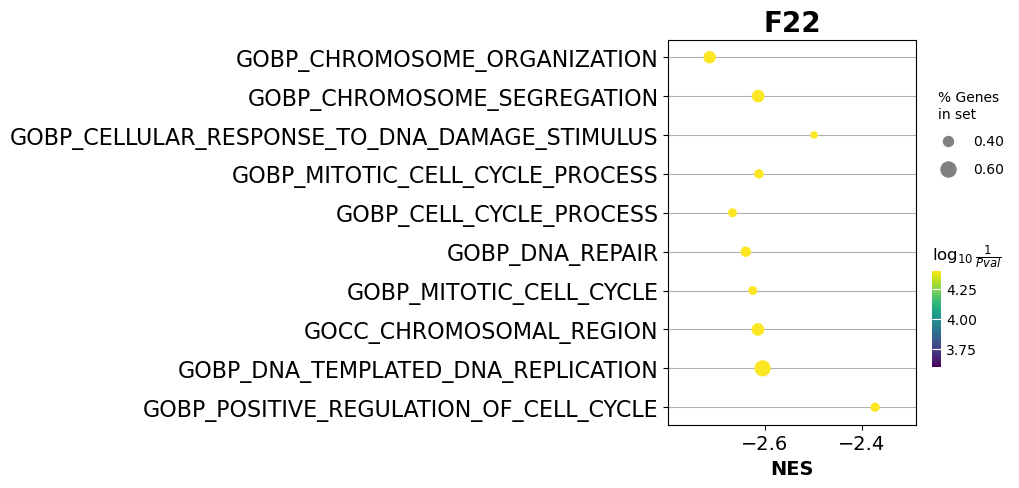

In [20]:
f = "F22"
rnk = pd.read_table(pj(output_dir, "all_rnks", f, f + ".rnk"), sep='\t',header=None)
pre_res = gp.prerank(rnk=rnk, # or rnk = rnk,
                    gene_sets='/root/data/analysis/GSEA/gmt_files/c5.all.v2023.1.Hs.symbols.gmt',
                    threads=4,
                    min_size=5,
                    max_size=1000,
                    permutation_num=1000, # reduce number to speed up testing
                    outdir="None", # don't write to disk
                    seed=6,
                    verbose=True, # see what's going on behind the scenes
                )
terms = pre_res.res2d.Term
ax = dotplot(pre_res.res2d,
                column="FDR q-val",
                title=f,
                cmap=plt.cm.viridis,
                size=3, # adjust dot size
                figsize=(4,5), 
                cutoff=0.25, 
            #  n_terms = 20,
                show_ring=False)
# plt.savefig(pj(output_dir, "all_rnks", f, f + "_dot.png"), bbox_inches='tight')
# plt.savefig(pj(output_dir, "all_rnks", f, f + "_dot.pdf"), format="pdf", bbox_inches="tight")

In [17]:
df = pre_res.res2d
df[(df["NES"].abs() > 1) & (df["NOM p-val"] < 0.05) & (df["FDR q-val"] < 0.25)]
df["ANES"] = df["NES"].abs()
df.sort_values(by="ANES").tail(20)


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,ANES
19,prerank,GOBP_PEPTIDE_ANTIGEN_ASSEMBLY_WITH_MHC_PROTEIN...,0.964356,2.509319,0.0,0.000062,0.001,11/11,3.83%,HLA-DQA1;HLA-DPA1;HLA-DRB1;HLA-DPB1;HLA-DRB5;H...,2.509319
18,prerank,GOBP_REGULATION_OF_T_CELL_ACTIVATION,0.543674,2.535231,0.0,0.000069,0.001,71/164,15.06%,TIGIT;CCL5;HLA-DQA1;EGR3;HLA-DPA1;HLA-DRB1;HLA...,2.535231
17,prerank,GOBP_REGULATION_OF_LYMPHOCYTE_ACTIVATION,0.52902,2.556407,0.0,0.000072,0.001,91/219,15.45%,TIGIT;CCL5;HLA-DQA1;EGR3;HLA-DPA1;HLA-DRB1;HLA...,2.556407
16,prerank,GOCC_ER_TO_GOLGI_TRANSPORT_VESICLE_MEMBRANE,0.914038,2.570604,0.0,0.000077,0.001,8/13,0.69%,HLA-DQA1;HLA-DPA1;HLA-DRB1;HLA-DPB1;HLA-DRB5;H...,2.570604
15,prerank,GOBP_B_CELL_MEDIATED_IMMUNITY,0.629398,2.578111,0.0,0.000082,0.001,30/71,10.24%,HLA-DQA1;HLA-DPA1;HLA-DRB1;HLA-DPB1;HLA-DRB5;H...,2.578111
14,prerank,GOCC_COPII_COATED_ER_TO_GOLGI_TRANSPORT_VESICLE,0.824695,2.585166,0.0,0.000087,0.001,8/19,0.69%,HLA-DQA1;HLA-DPA1;HLA-DRB1;HLA-DPB1;HLA-DRB5;H...,2.585166
13,prerank,GOCC_MHC_CLASS_II_PROTEIN_COMPLEX,0.964595,2.613355,0.0,0.0,0.0,12/12,3.83%,HLA-DQA1;HLA-DPA1;HLA-DRB1;HLA-DPB1;HLA-DRB5;H...,2.613355
12,prerank,GOCC_MHC_PROTEIN_COMPLEX,0.951851,2.663378,0.0,0.0,0.0,12/13,3.83%,HLA-DQA1;HLA-DPA1;HLA-DRB1;HLA-DPB1;HLA-DRB5;H...,2.663378
11,prerank,GOCC_COATED_VESICLE_MEMBRANE,0.733696,2.674463,0.0,0.0,0.0,14/42,6.00%,HLA-DQA1;HLA-DPA1;HLA-DRB1;HLA-DPB1;HLA-DRB5;H...,2.674463
10,prerank,GOBP_ANTIGEN_PROCESSING_AND_PRESENTATION_OF_PE...,0.850345,2.70023,0.0,0.0,0.0,16/22,6.17%,HLA-DQA1;HLA-DPA1;HLA-DRB1;HLA-DPB1;HLA-DRB5;H...,2.70023


In [25]:
def isfloat(x):
    try:
        float(x)
    except:
        return False
    else:
        return True
def process(df):
    # check if any values in `df[colname]` can't be coerced to floats
    can_be_coerced = df["FDR q-val"].map(isfloat).sum()
    if can_be_coerced < len(df):
        msg = "some value in %s could not be typecast to `float`" % self.colname
        raise ValueError(msg)
    # subset
    mask = df["FDR q-val"] <= 0.05
    if "FDR q-val" in ["Combined Score", "NES", "ES", "Odds Ratio"]:
        mask.loc[:] = True

    df = df.loc[mask]
    if len(df) < 1:
        msg = "Warning: No enrich terms when cutoff = %s" % 0.05
        raise ValueError(msg)
    cbar_title = "FDR q-val"
    # clip GSEA lower bounds
    # if self.colname in ["NOM p-val", "FDR q-val"]:
    #     df[self.colname].clip(1e-5, 1.0, inplace=True)
    # sorting the dataframe for better visualization
    colnd = {
        "Adjusted P-value": "FDR",
        "P-value": "Pval",
        "NOM p-val": "Pval",
        "FDR q-val": "FDR",
    }
    if "FDR q-val" in ["Adjusted P-value", "P-value", "NOM p-val", "FDR q-val"]:
        # get top_terms
        df = df.sort_values(by="FDR q-val")
        df["FDR q-val"].replace(
            0, method="bfill", inplace=True
        )  ## asending order, use bfill
        df = df.assign(p_inv=np.log10(1 / df["FDR q-val"].astype(float)))
        _t = colnd["FDR q-val"]
        colname = "p_inv"
        cbar_title = r"$\log_{10} \frac{1}{ " + _t + " }$"

    # get top terms; sort ascending
    df = df.sort_values(by="FDR q-val").tail(20)  # acending
    # get scatter area
    df = df.assign(Hits_ratio=1.0)  # if Overlap column missing
    return df

In [26]:
df = pre_res.res2d
data = process(df)
# data.to_csv("/root/data/DBP_sa_bc/result/analysis/wnn_rna/DBP_sa_bc/e1/fa/all_rnks/F5/F5terms.csv", index=True)

In [27]:
data

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes,p_inv,Hits_ratio
399,prerank,HP_HYPOPLASIA_OF_THE_RADIUS,-0.847058,-1.724266,0.001961,0.040303,0.998,3/8,5.23%,FANCI;RFWD3;FANCB,1.394660,1.0
398,prerank,GOBP_POSITIVE_REGULATION_OF_NUCLEASE_ACTIVITY,-0.93793,-1.724286,0.004376,0.040398,0.998,3/5,2.02%,PCNA;HMGB2;DDX11,1.393641,1.0
401,prerank,HP_NEOPLASM_OF_THE_BREAST,-0.687926,-1.723091,0.006319,0.040775,0.998,6/24,3.28%,BRCA1;BRCA2;MSH6;BARD1;MSH2;BLM,1.389605,1.0
400,prerank,GOBP_MICROTUBULE_POLYMERIZATION,-0.697058,-1.723262,0.0,0.040789,0.998,8/24,12.22%,STMN1;FBXO5;CENPJ;CDK5RAP2;HAUS2;PAK1;NEDD1;CL...,1.389456,1.0
403,prerank,GOBP_REGULATION_OF_HISTONE_H3_K4_METHYLATION,-0.896343,-1.720352,0.003976,0.042384,0.999,2/6,3.78%,BRCA1;PAXIP1,1.372799,1.0
405,prerank,HP_CACHEXIA,-0.743466,-1.71964,0.006969,0.042639,0.999,5/17,6.94%,CENPE;RBBP8;CENPJ;CEP152;PCNT,1.370193,1.0
407,prerank,HP_ABNORMALITY_IRIS_MORPHOLOGY,-0.542263,-1.718225,0.0,0.043429,0.999,16/97,8.76%,CENPF;BRCA1;BRCA2;FANCI;FANCD2;NSD2;RFWD3;MSH6...,1.362216,1.0
408,prerank,GOBP_REGULATION_OF_DNA_METHYLATION,-0.926482,-1.71792,0.0,0.043505,0.999,2/5,2.57%,BRCA1;MIS18A,1.361456,1.0
409,prerank,HP_FINGER_SYNDACTYLY,-0.618119,-1.717657,0.008721,0.043569,0.999,9/39,8.20%,BRCA1;BRCA2;FANCI;EZH2;FANCD2;RFWD3;FANCB;FANC...,1.360825,1.0
410,prerank,GOBP_ESTROUS_CYCLE,-0.935814,-1.716426,0.0,0.044205,0.999,1/5,0.37%,PCNA,1.354526,1.0
